In [20]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gzip
import shutil
import glob
import rioxarray as rxr
from scipy import stats, interpolate
from statsmodels.distributions.empirical_distribution import ECDF

In [5]:
# Set data directory
data_dir = "../../datasets/precipitation_chirps/chirps_tif"

## Precipitation pre-processing

### Read precipitation file

In [25]:
# Read precipitation data
precipitation_gha = xr.open_dataset('../../datasets/precipitation_chirps/precip_chirps_gha.nc')
precipitation_gha

/home/jovyan/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'gsmv6' loading failed:
No module named 'shxarray.core.xr_accessor'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/jovyan/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'icgem' loading failed:
No module named 'shxarray.core.xr_accessor'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/jovyan/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'shascii' loading failed:
No module named 'shxarray.core.xr_accessor'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/jovyan/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'sinex' loading failed:
No module named 'shxarray.core.xr_accessor'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:        (x: 591, y: 698, time: 250)
Coordinates:
    band           int64 ...
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
Data variables:
    spatial_ref    int64 ...
    precipitation  (time, y, x) float32 ...

In [71]:
precipitation_stacke = precipitation_gha.precipitation.stack(dims=['x', 'y', 'time'])
precipitation_stacke

<xarray.DataArray 'precipitation' (dims: 103129500)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    band     int64 ...
  * dims     (dims) object MultiIndex
  * x        (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38 51.38
  * y        (dims) float64 23.12 23.12 23.12 23.12 ... -11.73 -11.73 -11.73
  * time     (dims) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_DATETIME:          2015:01:30 07:43:45
    TIFFTAG_DOCUMENTNAME:      /home/CHIRPS/monthly/v2.0/africa/chirps-v2.0.2...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.3, Exelis Visual Information Solutions, ...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    units:                     mm
    grid_mapping:              spatial_ref

 Visualise the data

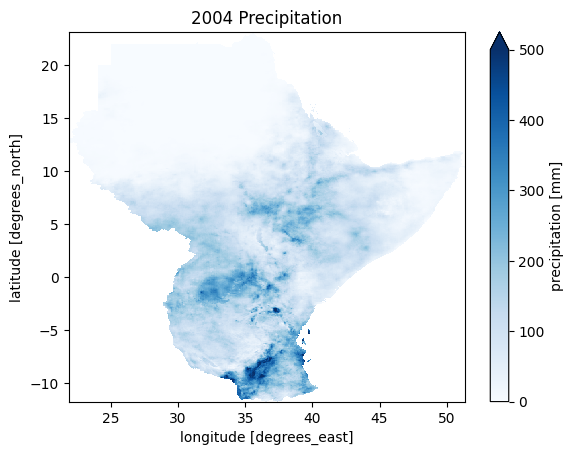

In [26]:
# Visualize sample year
sample_precip_gha = precipitation_gha['precipitation'].isel(time=0)
sample_precip_gha.plot(vmax=500, cmap="Blues")
plt.title('2004 Precipitation')
plt.show()

### Calculate baseline average

#### Process climatology

In [28]:
# Calculate monthly climatology (mean for each month over the years)
precipitation_clim = precipitation_gha.groupby("time.month").mean("time")

In [29]:
precipitation_clim

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, month: 12)
Coordinates:
    band           int64 1
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    spatial_ref    (month) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    precipitation  (month, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [31]:
# Calculate anomalies
precipitation_anomalies = precipitation_gha.groupby("time.month") - precipitation_clim

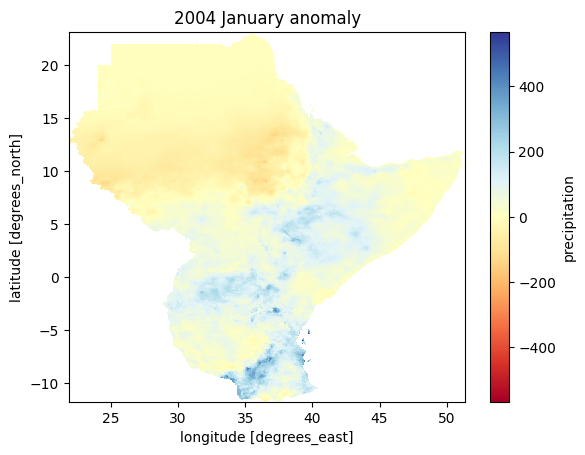

In [35]:
sample_anomaly = precipitation_anomalies['precipitation'].isel(time=0)
sample_anomaly.plot(cmap="RdYlBu")
plt.title('2004 January anomaly')
plt.show()

### Standardize the anomalies

In [36]:
# Calculate the standard deviation for each month over the years
precipitation_std = precipitation_gha.groupby("time.month").std("time")

# Calculate standardized anomalies
standardized_anomalies = precipitation_anomalies / precipitation_std

In [48]:
standardized_anomalies

<xarray.Dataset>
Dimensions:        (time: 250, x: 591, y: 698, month: 12)
Coordinates:
    band           (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    spatial_ref    (time, month) float64 nan nan nan nan nan ... nan nan nan nan
    precipitation  (time, y, x, month) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

#### Fit to marginal distribution

In [ ]:
# TODO: Implement fitting marginal distribution to the data

##### Remove NaN values

In [72]:
# Stack data to 1D

precipitation_stack = standardized_anomalies.precipitation.stack(dims=['x', 'y', 'time', 'month'])
precipitation_stack

<xarray.DataArray 'precipitation' (dims: 1237554000)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    band     (dims) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * dims     (dims) object MultiIndex
  * x        (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38 51.38
  * y        (dims) float64 23.12 23.12 23.12 23.12 ... -11.73 -11.73 -11.73
  * time     (dims) datetime64[ns] 2004-01-01 2004-01-01 ... 2024-10-01
  * month    (dims) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [73]:
precipitation_st = precipitation_stack[~np.isnan(precipitation_stack)]
precipitation_st

<xarray.DataArray 'precipitation' (dims: 1237554000)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    band     (dims) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * dims     (dims) object MultiIndex
  * x        (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38 51.38
  * y        (dims) float64 23.12 23.12 23.12 23.12 ... -11.73 -11.73 -11.73
  * time     (dims) datetime64[ns] 2004-01-01 2004-01-01 ... 2024-10-01
  * month    (dims) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

(array([1.28000000e+02, 1.42000000e+03, 1.84130000e+04, 8.98290000e+05,
        1.08141068e+09, 1.44208447e+08, 9.47461200e+06, 1.13785800e+06,
        2.47446000e+05, 8.13440000e+04, 3.21560000e+04, 1.45270000e+04,
        7.99300000e+03, 5.30200000e+03, 3.53900000e+03, 2.54400000e+03,
        1.85800000e+03, 1.47300000e+03, 1.03600000e+03, 8.89000000e+02,
        6.68000000e+02, 5.83000000e+02, 5.52000000e+02, 4.31000000e+02,
        3.20000000e+02, 2.46000000e+02, 1.94000000e+02, 1.64000000e+02,
        1.48000000e+02, 1.25000000e+02, 1.02000000e+02, 8.60000000e+01,
        7.60000000e+01, 8.70000000e+01, 6.00000000e+01, 6.20000000e+01,
        4.50000000e+01, 3.30000000e+01, 1.80000000e+01, 1.40000000e+01,
        3.00000000e+00, 5.00000000e+00, 9.00000000e+00, 7.00000000e+00,
        5.00000000e+00, 0.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        0.00000000e+00, 3.00000000e+00]),
 array([-13.53365326, -10.73763943,  -7.9416256 ,  -5.14561176,
         -2.34959817,   0.4464

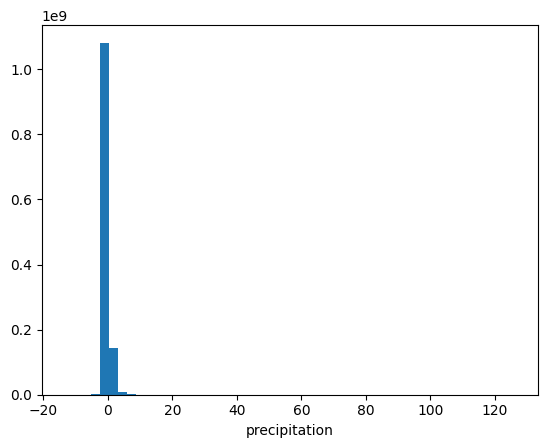

In [76]:
precipitation_st.plot.hist(bins=50)

In [77]:
norm_mean, norm_std = stats.norm.fit(precipitation_st)

In [ ]:
# Show the histogram
# fig, ax = plt.subplots(1, 1)
# ax.hist(precipitation_st, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim([x[0], x[-1]])
# ax.legend(loc='best', frameon=False)
# plt.show()


# Plotting the histogram and the fitted Normal distribution
plt.figure(figsize=(10, 6))
plt.hist(precipitation_st, bins='auto', density=True, histtype='stepfilled', alpha=0.7, color='blue', label='Data')

# Generate x values for plotting the fitted distribution
x = np.linspace(min(precipitation_st), max(precipitation_st), 100)
pdf_fitted = stats.norm.pdf(x, norm_mean, norm_std)
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Normal')

plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.title('Histogram of Precipitation Data with Fitted Normal Distribution')
plt.legend()
plt.show()

In [ ]:
# Q-Q Plot
stats.probplot(precipitation_st, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [ ]:
shape, loc, scale = stats.gamma.fit(precipitation_st)

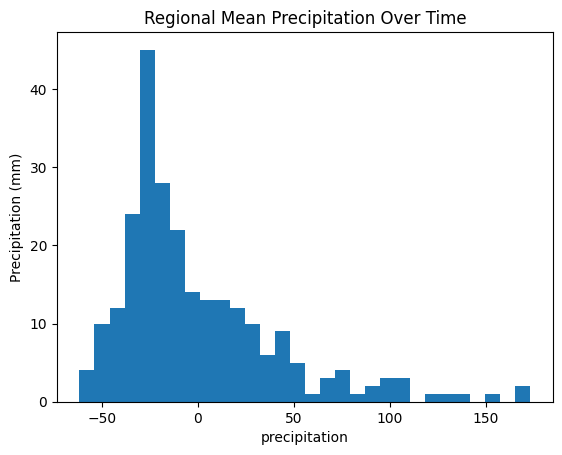

In [42]:
# Subset data for a bounding box (e.g., Greater Horn of Africa)
region = precipitation_anomalies['precipitation'].sel(x=slice(33, 43), y=slice(5, -5))

# Calculate mean precipitation over space or time within the region
region_mean_time = region.mean(dim=["x", "y"])
region_mean_time.plot.hist(bins=30)
plt.title("Regional Mean Precipitation Over Time")
plt.ylabel("Precipitation (mm)")
plt.show()


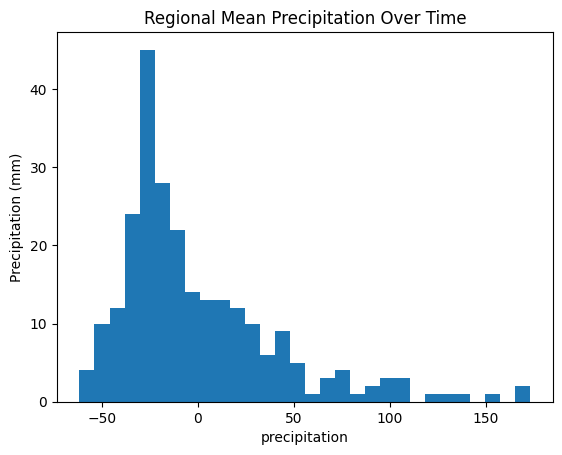

In [41]:
# Subset data for a bounding box (e.g., Greater Horn of Africa)
region = precipitation_anomalies['precipitation'].sel(x=slice(33, 43), y=slice(5, -5))

# Calculate mean precipitation over space or time within the region
region_mean_time = region.mean(dim=["x", "y"])
region_mean_time.plot.hist(bins=30)
plt.title("Regional Mean Precipitation Over Time")
plt.ylabel("Precipitation (mm)")
plt.show()


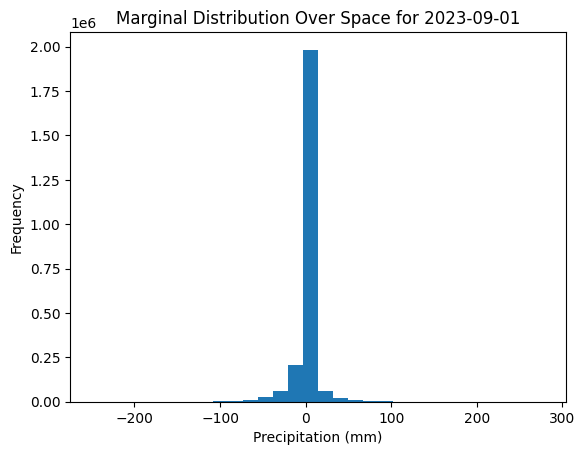

In [93]:
# Select a specific time point
specific_time = "2023-09-01"

# Extract spatial precipitation data
spatial_data = precipitation_anomalies.sel(time=specific_time)

# Flatten the data and plot histogram
spatial_data.plot.hist(bins=30)
plt.title(f"Marginal Distribution Over Space for {specific_time}")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()


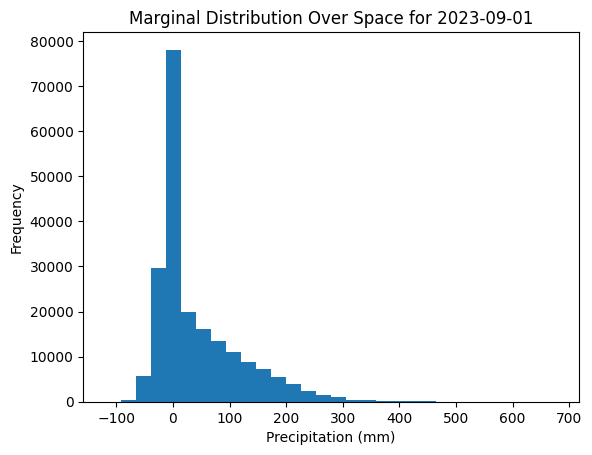

In [43]:
# Select a specific time point
specific_time = "2023-09-01"

# Extract spatial precipitation data
spatial_data = precipitation_anomalies['precipitation'].sel(time=specific_time)

# Flatten the data and plot histogram
spatial_data.plot.hist(bins=30)
plt.title(f"Marginal Distribution Over Space for {specific_time}")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()


In [66]:
# Check for non-finite values
non_finite = np.isnan(standardized_anomalies['precipitation']) | np.isinf(standardized_anomalies['precipitation'])
print(non_finite.sum())  # Number of non-finite values

<xarray.DataArray 'precipitation' ()>
array(619110000)


In [75]:
precipitation = clean_data.fillna(0)  # Replace NaN with 0
precipitation = xr.where(np.isinf(precipitation), 0, precipitation)  # Replace inf with 0

In [31]:
stack = precipitation_gha.stack(dims=['x', 'y', 'time'])

In [39]:
y = stack.precipitation[~np.isnan(stack.precipitation)]

<xarray.DataArray 'precipitation' ()>
array(53.39169, dtype=float32)
Coordinates:
    band     int64 ...
<xarray.DataArray 'precipitation' ()>
array(70.98170471)
Coordinates:
    band     int64 ...


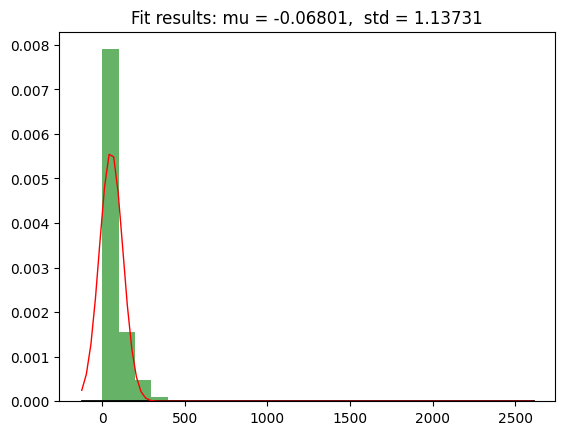

In [42]:
data = stats.norm.rvs(loc=0,scale=1,size=200)

mu1 = np.mean(y)

std1 = np.std(y)

print(mu1)
print(std1)

mu, std = stats.norm.fit(data)

plt.hist(y, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
q = stats.norm.pdf(x, mu1, std1)
plt.plot(x, p, 'k', linewidth=2)
plt.plot(x, q, 'r', linewidth=1)
title = "Fit results: mu = %.5f,  std = %.5f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
# TODO: Transform data to uniform margins
